*  Before starting, click "Runtime" in the top panel, select "Change runtime type" and then choose "GPU"

*  This tutorial follows the affinities tutorial, and is therefore condensed. Check out the affinities tutorial (**train_affinities.ipynb**) if there is any confusion throughout

*  Try running each cell consecutively to see what is happening before changing things around

*  Some cells are collapsed by default, these are generally utility functions or are expanded by defaullt in a previous tutorial. Double click to expand/collapse

*  Sometimes colab can be slow when training, if this happens you may need to restart the runtime. also, you generally can only run one session at a time.

In [1]:
#@title import packages

import gunpowder as gp
import h5py
import io
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import torch
import zarr

from funlib.learn.torch.models import UNet, ConvPass
from gunpowder.torch import Train
from lsd.train.gp import AddLocalShapeDescriptor
from tqdm import tqdm

%matplotlib inline
logging.basicConfig(level=logging.INFO)

In [2]:
#@title utility function to view labels

# matplotlib uses a default shader
# we need to recolor as unique objects

def create_lut(labels):

    max_label = np.max(labels)

    lut = np.random.randint(
            low=0,
            high=255,
            size=(int(max_label + 1), 3),
            dtype=np.uint8)

    lut = np.append(
            lut,
            np.zeros(
                (int(max_label + 1), 1),
                dtype=np.uint8) + 255,
            axis=1)

    lut[0] = 0
    colored_labels = lut[labels]

    return colored_labels

In [3]:
#@title utility  function to download / save data as zarr

def create_data(
    url, 
    name, 
    offset, 
    resolution,
    sections=None,
    squeeze=True):

  in_f = h5py.File(io.BytesIO(requests.get(url).content), 'r')

  raw = in_f['volumes/raw']
  labels = in_f['volumes/labels/neuron_ids']
  
  container = zarr.open(name, 'a')

  if sections is None:
    sections=range(raw.shape[0]-1)

  for index, section in enumerate(sections):

    print(f'Writing data for section {section}')

    raw_slice = raw[section]
    labels_slice = labels[section]

    if squeeze:
      raw_slice = np.squeeze(raw_slice)
      labels_slice = np.squeeze(labels_slice)

    for ds_name, data in [
        ('raw', raw_slice),
        ('labels', labels_slice)]:
        
        container[f'{ds_name}/{index}'] = data
        container[f'{ds_name}/{index}'].attrs['offset'] = offset
        container[f'{ds_name}/{index}'].attrs['resolution'] = resolution

In [4]:
#@title utility function to view a batch

# matplotlib.pyplot wrapper to view data
# default shape should be 2 - 2d data

def imshow(
        raw=None,
        ground_truth=None,
        target=None,
        prediction=None,
        h=None,
        shader='jet',
        subplot=True,
        channel=0,
        target_name='target',
        prediction_name='prediction'):

    rows = 0

    if raw is not None:
        rows += 1
        cols = raw.shape[0] if len(raw.shape) > 2 else 1
    if ground_truth is not None:
        rows += 1
        cols = ground_truth.shape[0] if len(ground_truth.shape) > 2 else 1
    if target is not None:
        rows += 1
        cols = target.shape[0] if len(target.shape) > 2 else 1
    if prediction is not None:
        rows += 1
        cols = prediction.shape[0] if len(prediction.shape) > 2 else 1

    if subplot:
        fig, axes = plt.subplots(
            rows,
            cols,
            figsize=(10, 4),
            sharex=True,
            sharey=True,
            squeeze=False)

    if h is not None:
        fig.subplots_adjust(hspace=h)

    def wrapper(data,row,name="raw"):

        if subplot:
            if len(data.shape) == 2:
                if name == 'raw':
                    axes[0][0].imshow(data, cmap='gray')
                    axes[0][0].set_title(name)
                else:
                    axes[row][0].imshow(create_lut(data))
                    axes[row][0].set_title(name)

            elif len(data.shape) == 3:
                for i, im in enumerate(data):
                    if name == 'raw':
                        axes[0][i].imshow(im, cmap='gray')
                        axes[0][i].set_title(name)
                    else:
                        axes[row][i].imshow(create_lut(im))
                        axes[row][i].set_title(name)

            else:
                for i, im in enumerate(data):
                    axes[row][i].imshow(im[channel], cmap=shader)
                    axes[row][i].set_title(name)


        else:
            if name == 'raw':
                plt.imshow(data, cmap='gray')
            if name == 'labels':
                plt.imshow(data, alpha=0.5)

    row=0 

    if raw is not None:
        wrapper(raw,row=row)
        row += 1
    if ground_truth is not None:
        wrapper(ground_truth,row=row,name='labels')
        row += 1
    if target is not None:
        wrapper(target,row=row,name=target_name)
        row += 1
    if prediction is not None:
        wrapper(prediction,row=row,name=prediction_name)
        row += 1

    plt.show()

In [5]:
create_data(
    'https://cremi.org/static/data/sample_A_20160501.hdf',
    'training_data.zarr',
    offset=[0,0],
    resolution=[4,4])

Writing data for section 0
Writing data for section 1
Writing data for section 2
Writing data for section 3
Writing data for section 4
Writing data for section 5
Writing data for section 6
Writing data for section 7
Writing data for section 8
Writing data for section 9
Writing data for section 10
Writing data for section 11
Writing data for section 12
Writing data for section 13
Writing data for section 14
Writing data for section 15
Writing data for section 16
Writing data for section 17
Writing data for section 18
Writing data for section 19
Writing data for section 20
Writing data for section 21
Writing data for section 22
Writing data for section 23
Writing data for section 24
Writing data for section 25
Writing data for section 26
Writing data for section 27
Writing data for section 28
Writing data for section 29
Writing data for section 30
Writing data for section 31
Writing data for section 32
Writing data for section 33
Writing data for section 34
Writing data for section 35
Wr

In [6]:
voxel_size = gp.Coordinate((4, 4))

input_shape = gp.Coordinate((164, 164))
output_shape = gp.Coordinate((124, 124))

input_size = input_shape * voxel_size
output_size = output_shape * voxel_size

In [8]:
# weighted mean squared error loss

class WeightedMSELoss(torch.nn.MSELoss):

    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, prediction, target, weights):

        scaled = (weights * (prediction - target) ** 2)

        if len(torch.nonzero(scaled)) != 0:

            mask = torch.masked_select(scaled, torch.gt(weights, 0))
            loss = torch.mean(mask)

        else:
            loss = torch.mean(scaled)

        return loss
        
# here we'll wrap our pipeline in a function to make it easy to call in subsequent cells

def train(
    iterations,
    batch_size,
    show_every,
    show_gt=True,
    show_pred=False,
    channels={'offset in y': 0}):
    
    raw = gp.ArrayKey('RAW')
    labels = gp.ArrayKey('LABELS')
    gt_lsds = gp.ArrayKey('GT_LSDS')
    lsds_weights = gp.ArrayKey('LSDS_WEIGHTS')
    pred_lsds = gp.ArrayKey('PRED_LSDS')
    
    request = gp.BatchRequest()

    request.add(raw, input_size)
    request.add(labels, output_size)
    request.add(gt_lsds, output_size)
    request.add(lsds_weights, output_size)
    request.add(pred_lsds, output_size)

    num_samples = 124
    num_fmaps = 12
    
    ds_fact = [(2,2),(2,2)]
    num_levels = len(ds_fact) + 1
    ksd = [[(3,3), (3,3)]]*num_levels
    ksu = [[(3,3), (3,3)]]*(num_levels - 1)

    # create unet
    unet = UNet(
      in_channels=1,
      num_fmaps=num_fmaps,
      fmap_inc_factor=5,
      downsample_factors=ds_fact,
      kernel_size_down=ksd,
      kernel_size_up=ksu,
      constant_upsample=True)

    # need 6 output channels (lsd on 2d data is 6 dimensional)
    # LSD[0:1] = mean offset in y
    # LSD[1:2] = mean offset in x
    # LSD[2:3] = orientation in y
    # LSD[3:4] = orientation in x
    # LSD[4:5] = change in orientation y-x
    # LSD[5:6] = size (voxel count)

    model = torch.nn.Sequential(
        unet,
        ConvPass(num_fmaps, 6, [[1, 1]], activation='Sigmoid'))

    loss = WeightedMSELoss()

    optimizer = torch.optim.Adam(lr=0.5e-4, params=model.parameters())

    sources = tuple(
        gp.ZarrSource(
            'training_data.zarr',  
            {
                raw: f'raw/{i}',
                labels: f'labels/{i}'
            },  
            {
                raw: gp.ArraySpec(interpolatable=True),
                labels: gp.ArraySpec(interpolatable=False)
            }) + 
            gp.Normalize(raw) +
            gp.RandomLocation()
            for i in range(num_samples)
        )

    # raw: (h, w)
    # labels: (h, w)

    pipeline = sources

    pipeline += gp.RandomProvider()

    pipeline += gp.SimpleAugment()

    pipeline += gp.IntensityAugment(
        raw,
        scale_min=0.9,
        scale_max=1.1,
        shift_min=-0.1,
        shift_max=0.1)

    pipeline += gp.GrowBoundary(labels)

    # calculate lsds on labels.
    pipeline += AddLocalShapeDescriptor(
        labels,
        gt_lsds,
        lsds_mask=lsds_weights,
        sigma=80,
        downsample=2)

    # raw: (h, w)
    # labels: (h, w)
    # gt_lsds: (6, h, w)

    # add "channel" dimensions
    pipeline += gp.Unsqueeze([raw])

    # raw: (1, h, w)
    # gt_lsds: (6, h, w)
    # lsds weights: (6, h, w)

    pipeline += gp.Stack(batch_size)

    # raw: (b, 1, h, w)
    # gt_lsds: (b, 6, h, w)
    # lsds weights: (b, 6, h, w)
    
    pipeline += gp.PreCache(num_workers=10)

    pipeline += Train(
        model,
        loss,
        optimizer,
        inputs={
            'input': raw
        },
        outputs={
            0: pred_lsds
        },
        loss_inputs={
            0: pred_lsds,
            1: gt_lsds,
            2: lsds_weights
        },
        log_dir='train_lsds_logs')
    
    with gp.build(pipeline):
        progress = tqdm(range(iterations))
        for i in progress:
            batch = pipeline.request_batch(request)

            start = request[labels].roi.get_begin()/voxel_size
            end = request[labels].roi.get_end()/voxel_size

            if i % show_every == 0:
              
              imshow(raw=np.squeeze(batch[raw].data[:,:,start[0]:end[0],start[1]:end[1]]))
              imshow(ground_truth=batch[labels].data)

              for n,c in channels.items():
                
                if show_gt:
                  imshow(target=batch[gt_lsds].data, target_name='gt '+n, channel=c)
                if show_pred:
                  imshow(prediction=batch[pred_lsds].data, prediction_name='pred '+n, channel=c)

            progress.set_description(f'Training iteration {i}') 
            pass

In [10]:
np.bool = np.bool_

INFO:gunpowder.torch.nodes.train:Starting training from scratch
INFO:gunpowder.torch.nodes.train:Using device cuda
  0%|          | 0/1 [00:00<?, ?it/s]INFO:gunpowder.nodes.precache:starting new set of workers (10, cache size 50)...
INFO:gunpowder.nodes.generic_train:Train process: iteration=1 loss=0.032609 time=0.335575


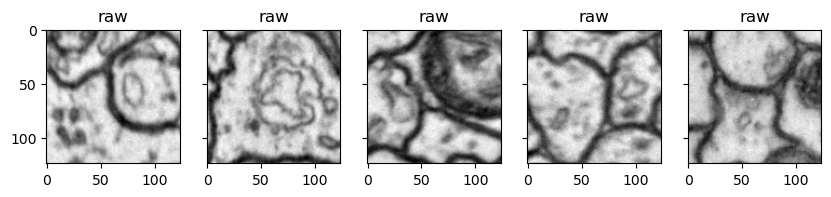

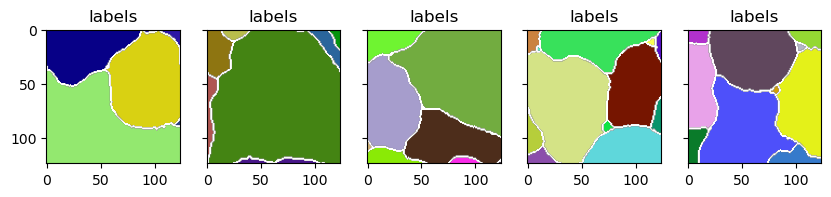

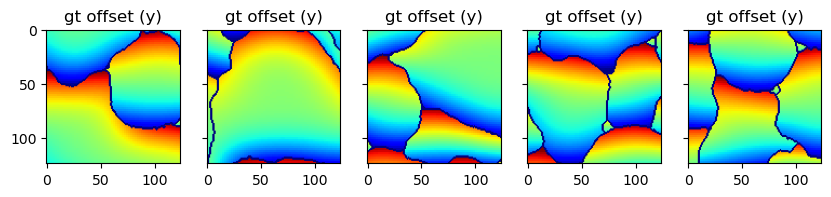

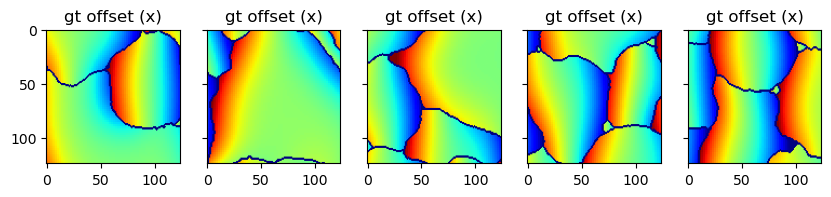

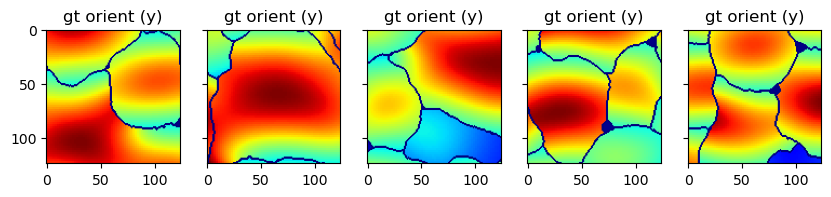

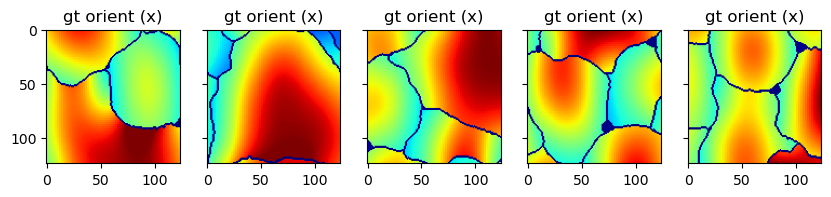

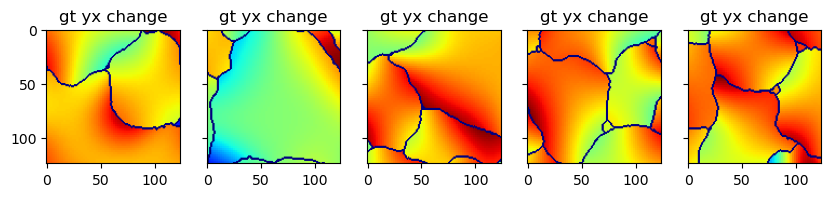

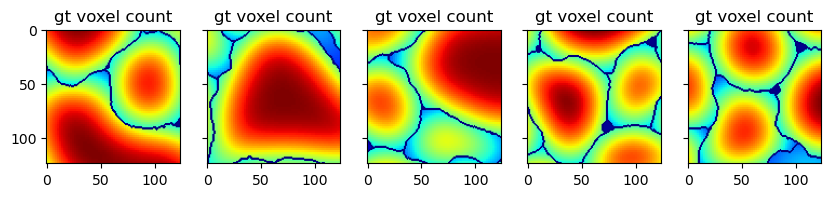

Training iteration 0: 100%|██████████| 1/1 [00:05<00:00,  5.23s/it]INFO:gunpowder.producer_pool:terminating workers...
INFO:gunpowder.producer_pool:joining workers...
INFO:gunpowder.producer_pool:done



In [11]:
# view a batch of ground truth lsds, no need to show predicted lsds yet

channels = {
    'offset (y)': 0,
    'offset (x)': 1,
    'orient (y)': 2,
    'orient (x)': 3,
    'yx change': 4,
    'voxel count': 5
}

train(iterations=1, batch_size=5, show_every=1, channels=channels)

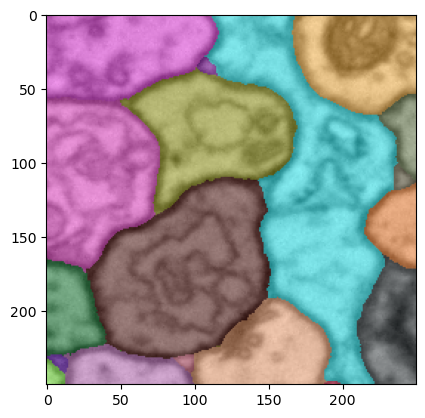

In [12]:
# can also calculate lsds without gunpowder (just a numpy array)

from lsd.train import local_shape_descriptor

f = zarr.open('training_data.zarr')
test_raw = f['raw/0'][:]
test_labels = f['labels/0'][:]

# just take the a 250x250 voxel patch from the corner
test_raw = test_raw[0:250, 0:250]
test_labels = test_labels[0:250, 0:250]

plt.imshow(test_raw, cmap='gray')
plt.imshow(create_lut(test_labels), alpha=0.5)

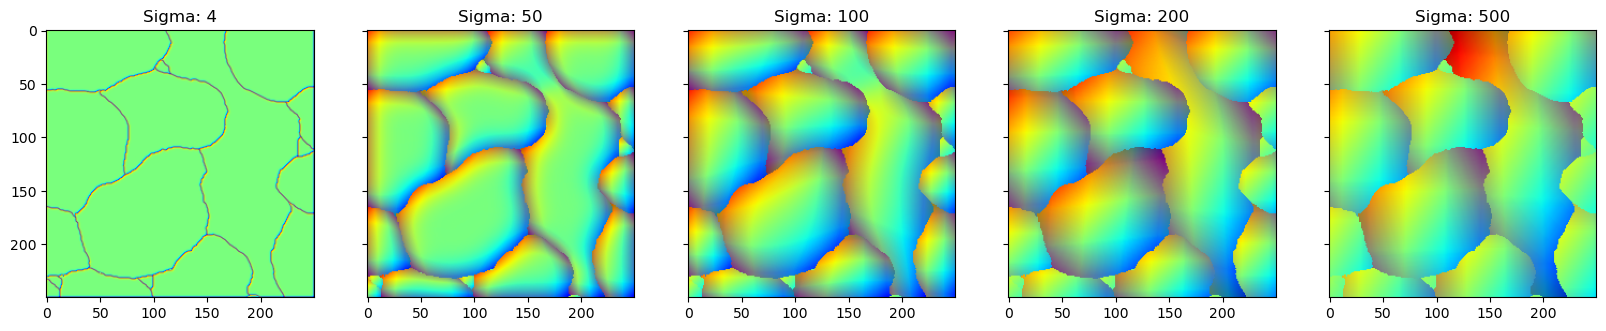

In [13]:
# test different sigmas for growing the gaussian (want something that works well for all sized processes)
# too small of a sigma decreases contrast at boundaries
# too high of a sigma decreases the gradient across the object
# in this case a sigma of 100 seems to be a good bet - the mean offset should make objects look 3d

sigmas = [4, 50, 100, 200, 500]

fig, axes = plt.subplots(
            1,
            5,
            figsize=(20, 6),
            sharex=True,
            sharey=True,
            squeeze=False)

for i, sig in enumerate(sigmas):
  
  lsds = local_shape_descriptor.get_local_shape_descriptors(
              segmentation=test_labels,
              sigma=(sig,)*3,
              voxel_size=voxel_size)
  
  # view mean offset component (x & y overlay)
  axes[0][i].imshow(np.squeeze(lsds[0,:,:]), cmap='jet')
  axes[0][i].imshow(np.squeeze(lsds[1,:,:]), cmap='jet', alpha=0.5)
  axes[0][i].set_title(f'Sigma: {str(sig)}')

INFO:gunpowder.torch.nodes.train:Starting training from scratch
INFO:gunpowder.torch.nodes.train:Using device cuda
  0%|          | 0/1001 [00:00<?, ?it/s]INFO:gunpowder.nodes.precache:starting new set of workers (10, cache size 50)...
INFO:gunpowder.nodes.generic_train:Train process: iteration=1 loss=0.036774 time=0.050366


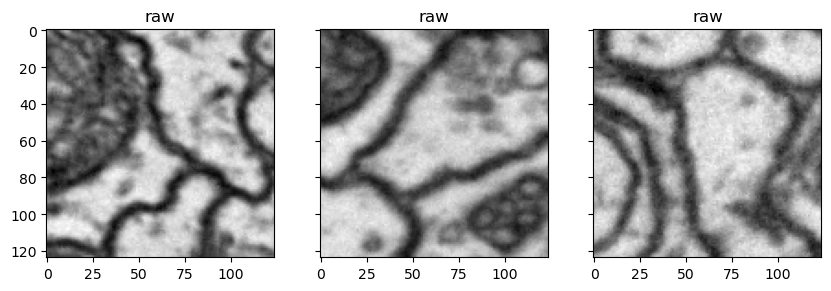

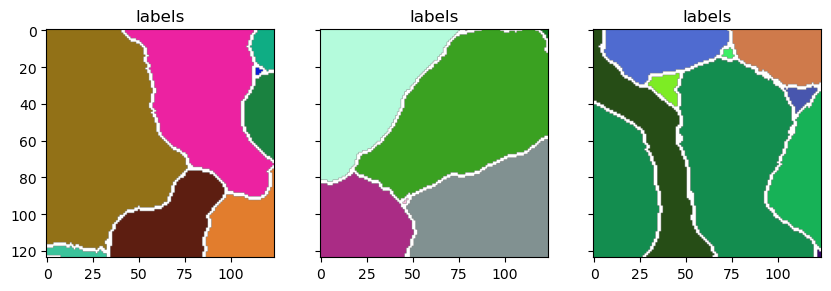

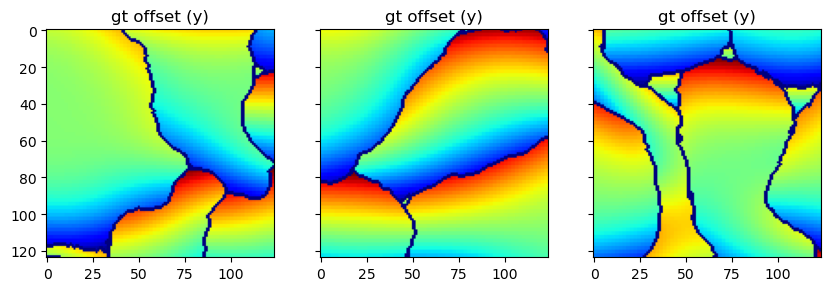

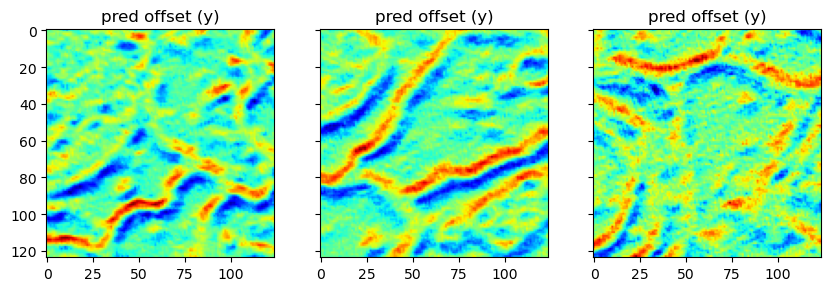

Training iteration 99:  10%|▉         | 100/1001 [00:12<01:47,  8.42it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=101 loss=0.035201 time=0.020485


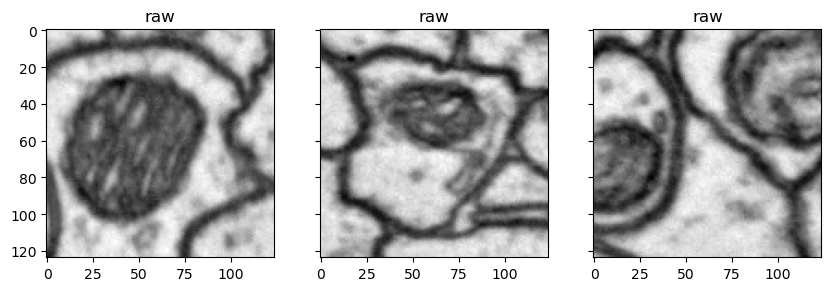

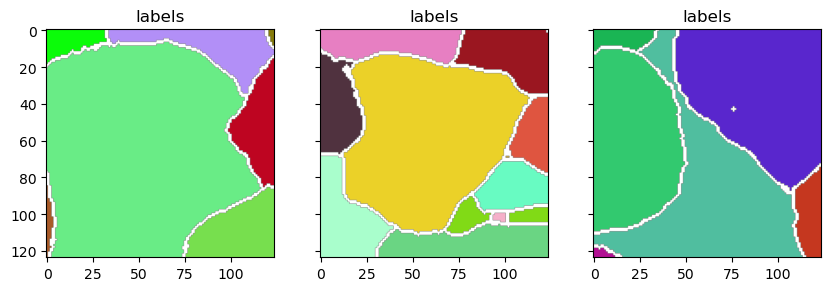

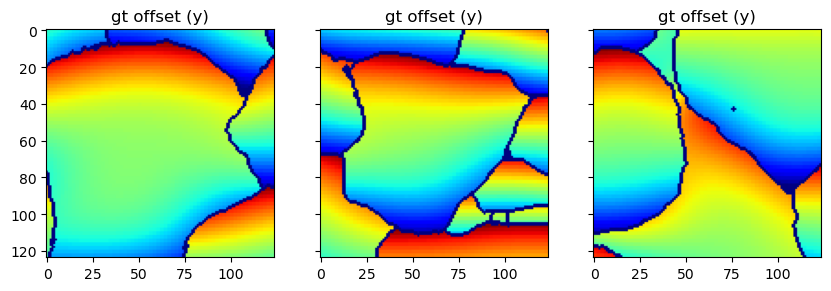

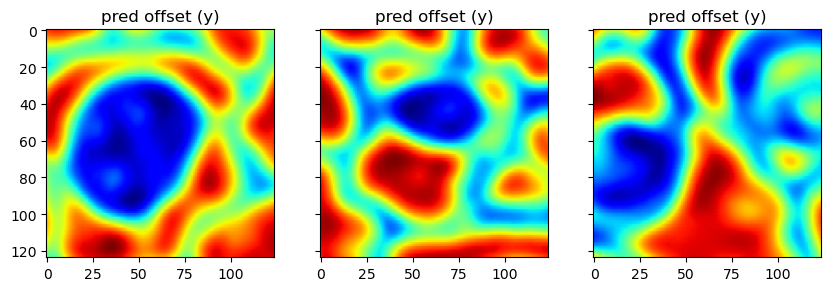

Training iteration 199:  20%|█▉        | 200/1001 [00:24<01:16, 10.47it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=201 loss=0.033220 time=0.007179


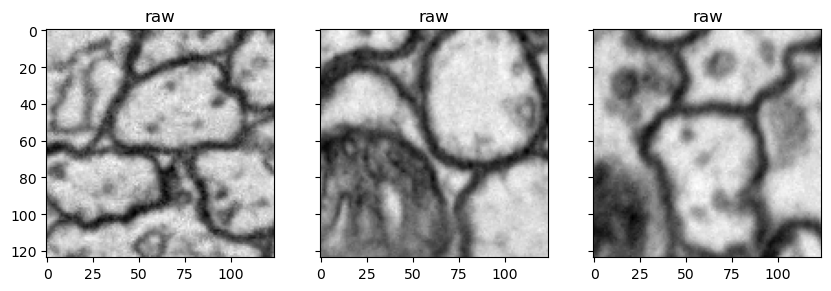

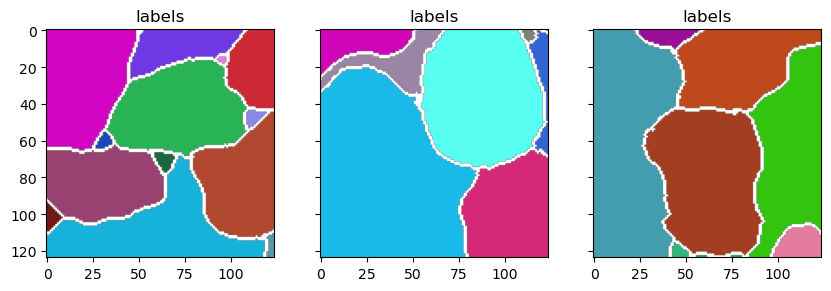

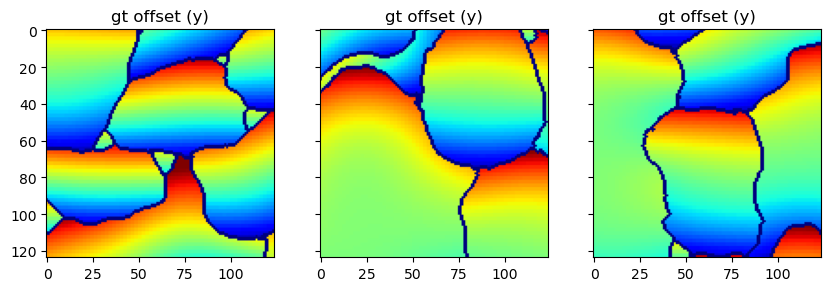

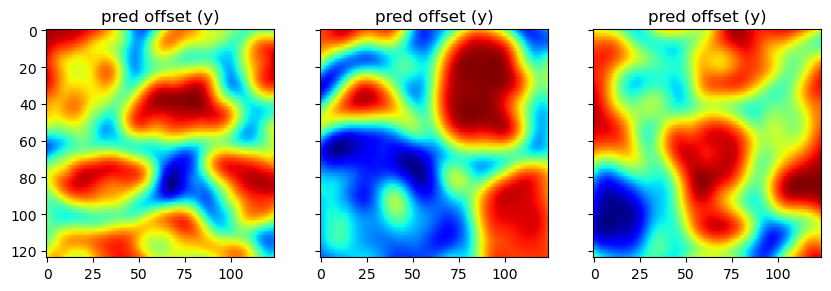

Training iteration 299:  30%|██▉       | 300/1001 [00:36<01:01, 11.31it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=301 loss=0.034178 time=0.015037


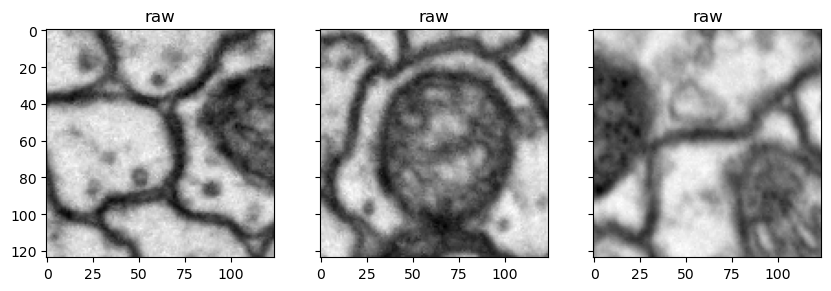

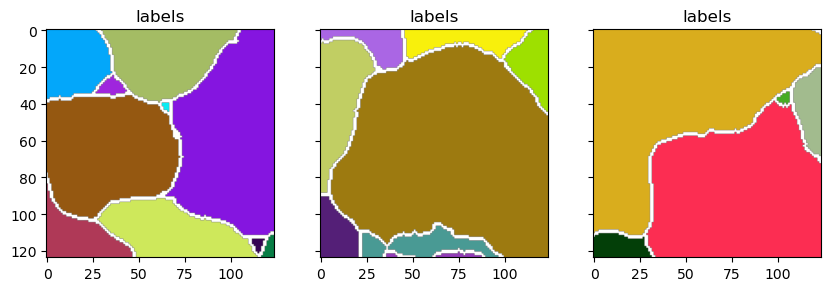

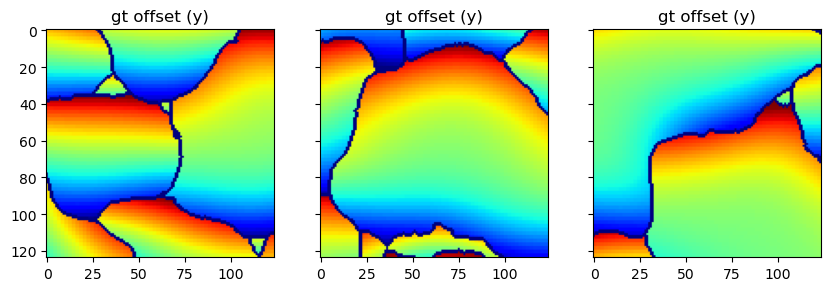

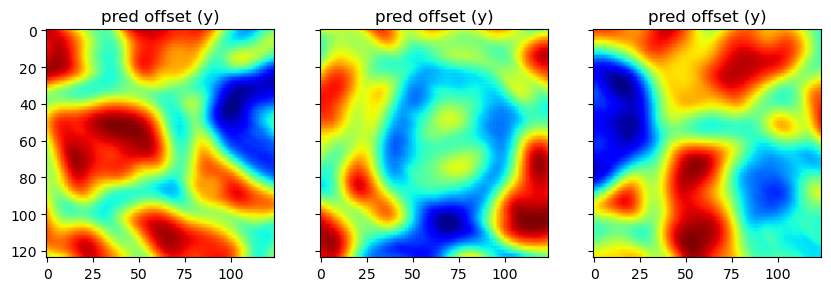

Training iteration 399:  40%|███▉      | 399/1001 [00:47<00:53, 11.31it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=401 loss=0.030336 time=0.008067


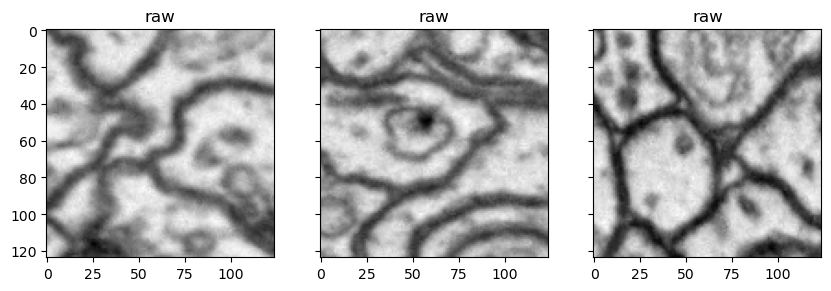

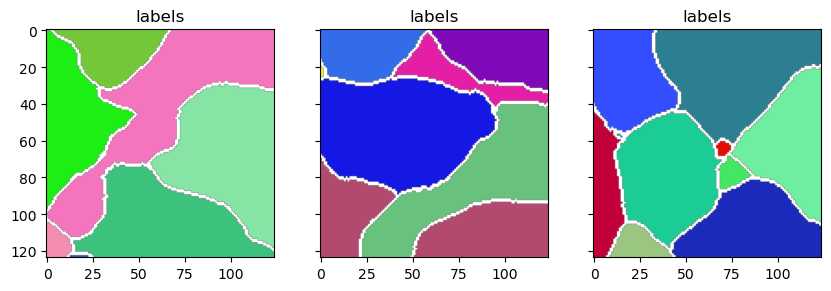

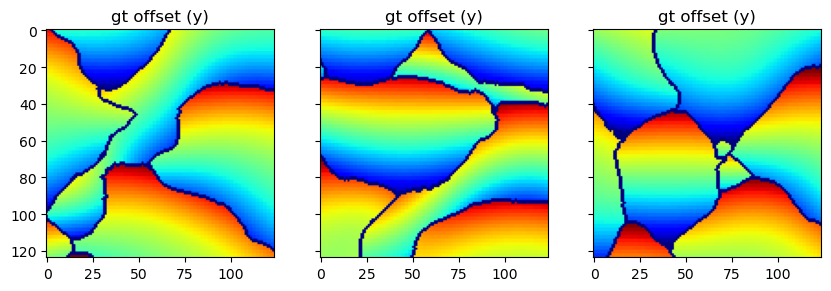

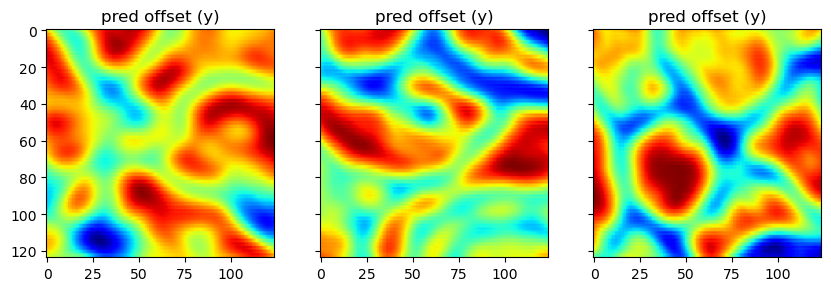

Training iteration 499:  50%|████▉     | 499/1001 [00:58<00:51,  9.66it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=501 loss=0.033422 time=0.008267


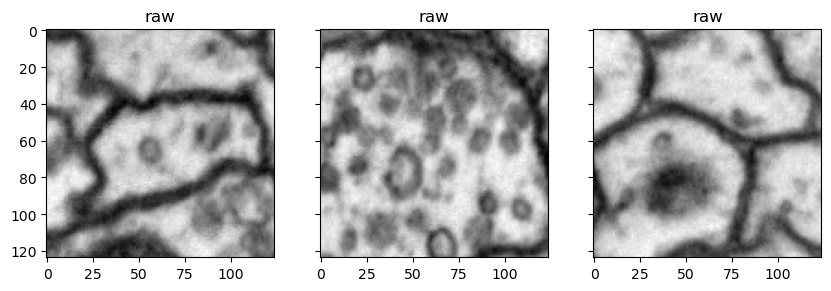

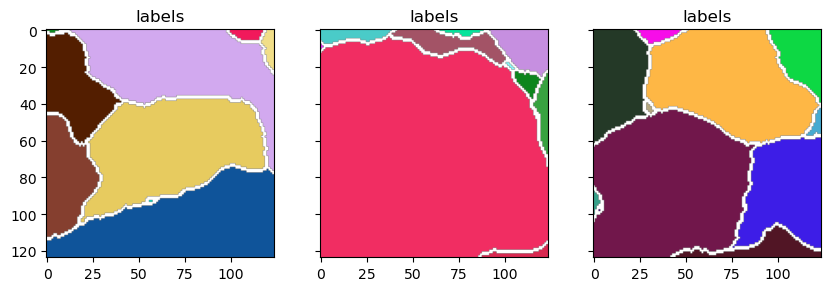

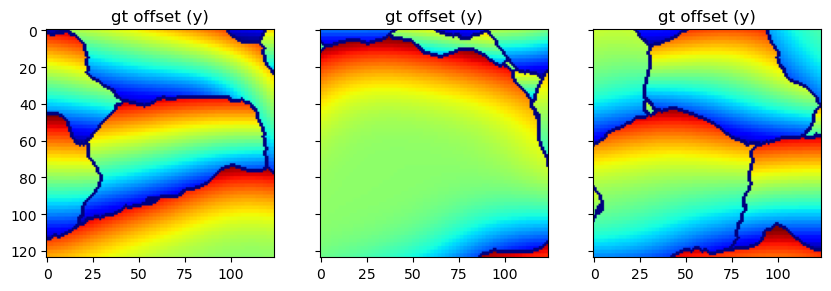

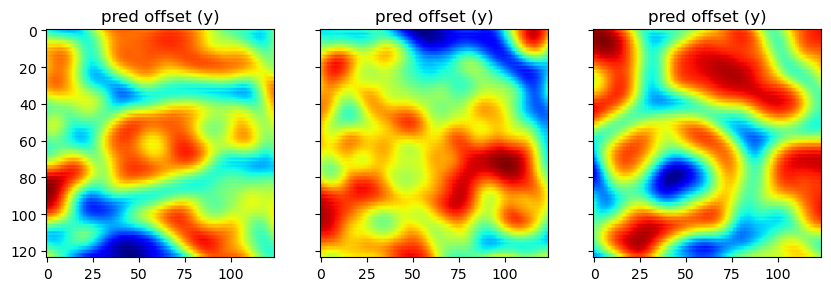

Training iteration 599:  60%|█████▉    | 598/1001 [01:09<00:43,  9.23it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=601 loss=0.030048 time=0.008007


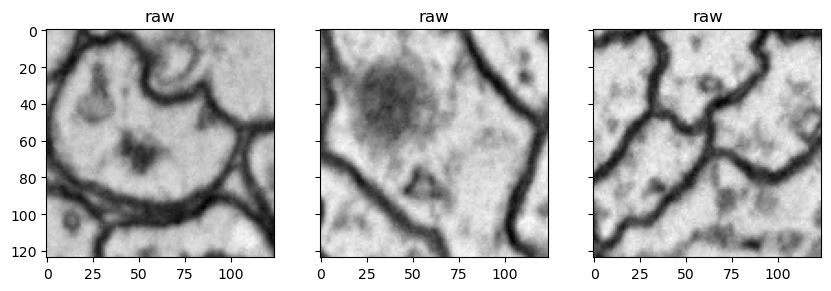

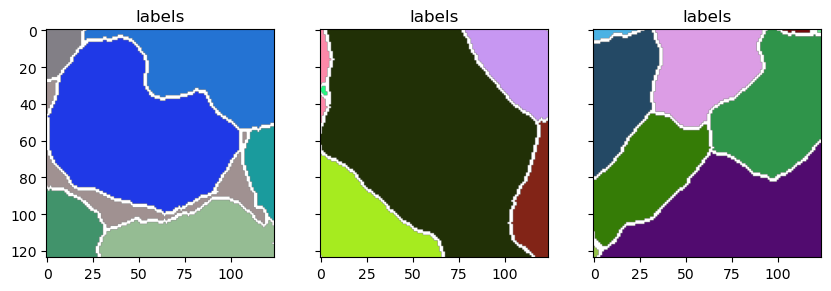

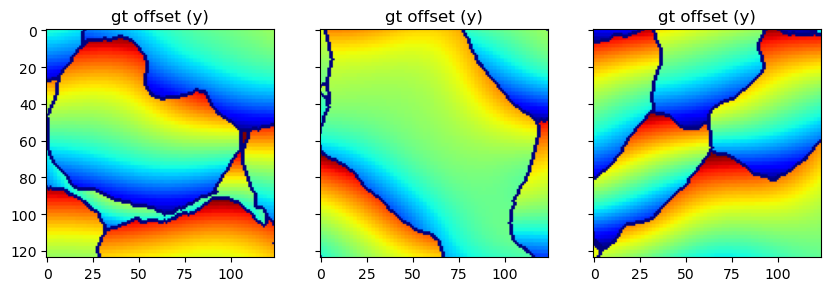

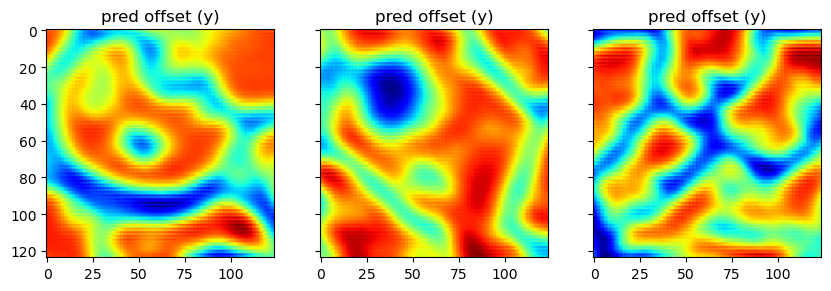

Training iteration 699:  70%|██████▉   | 700/1001 [01:21<00:30,  9.84it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=701 loss=0.034923 time=0.009373


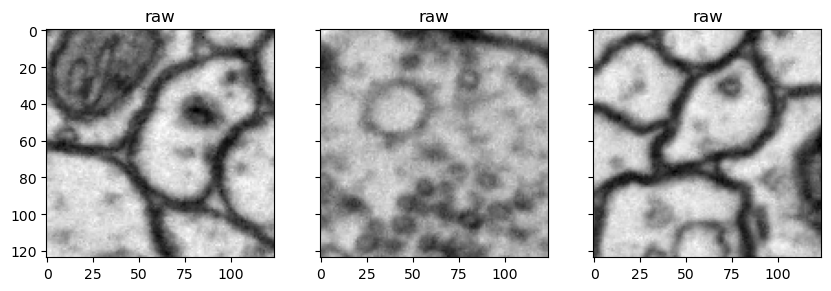

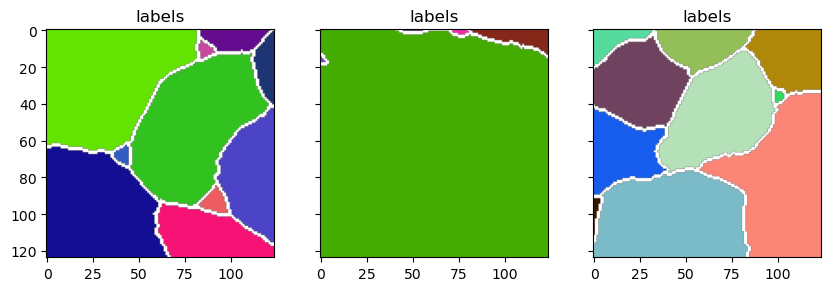

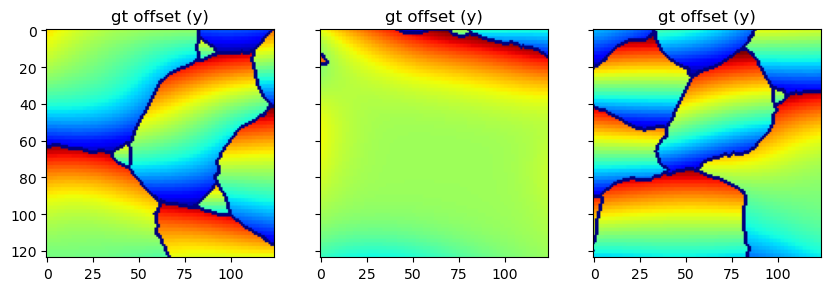

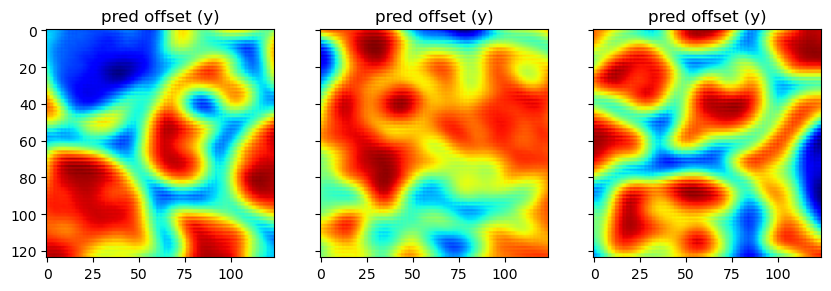

Training iteration 799:  80%|███████▉  | 799/1001 [01:32<00:26,  7.61it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=801 loss=0.028992 time=0.008812


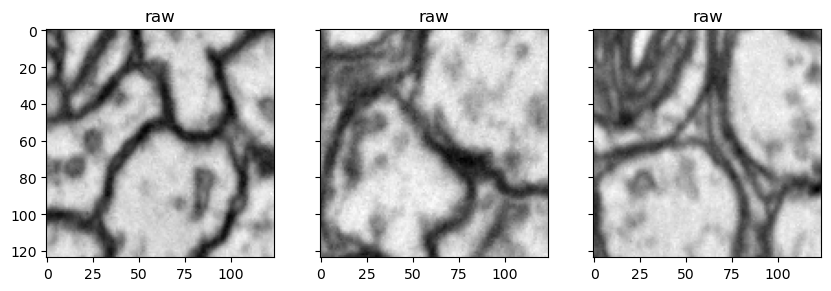

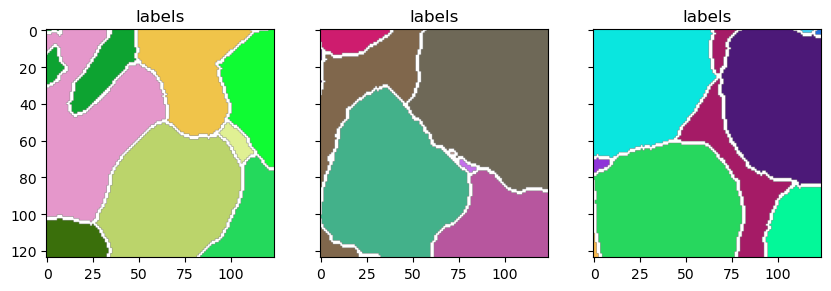

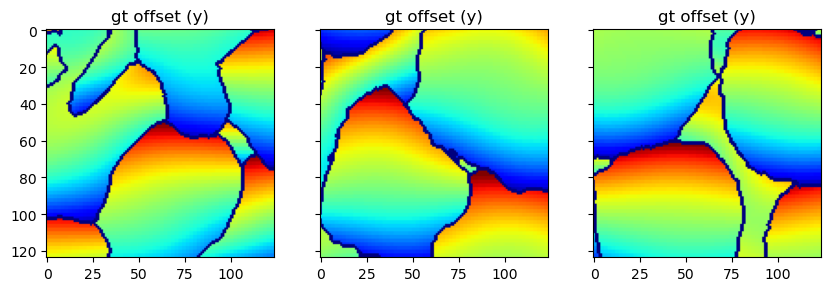

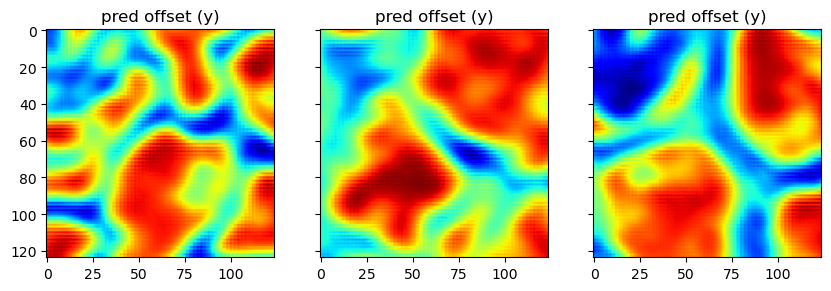

Training iteration 899:  90%|████████▉ | 899/1001 [01:43<00:11,  8.56it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=901 loss=0.033585 time=0.007440


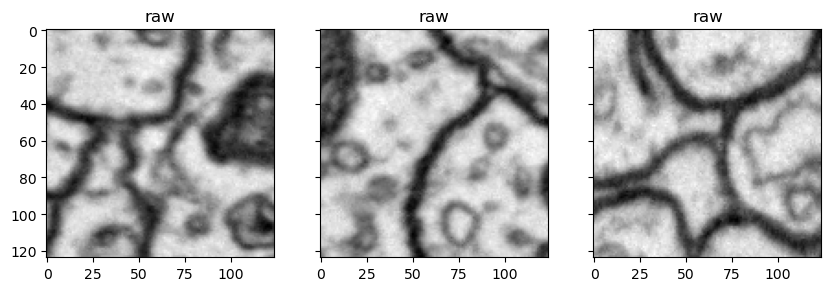

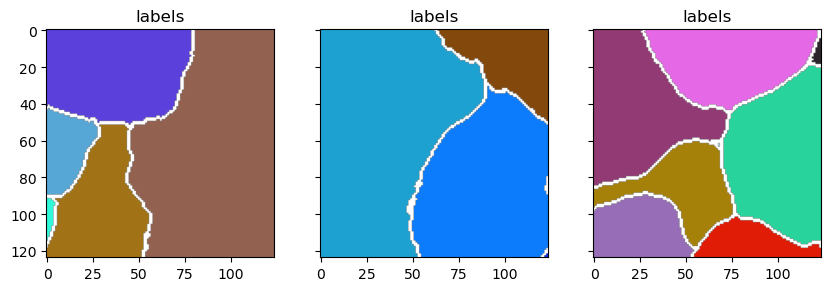

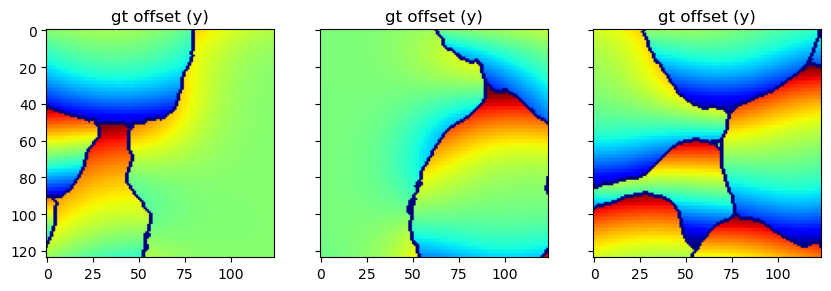

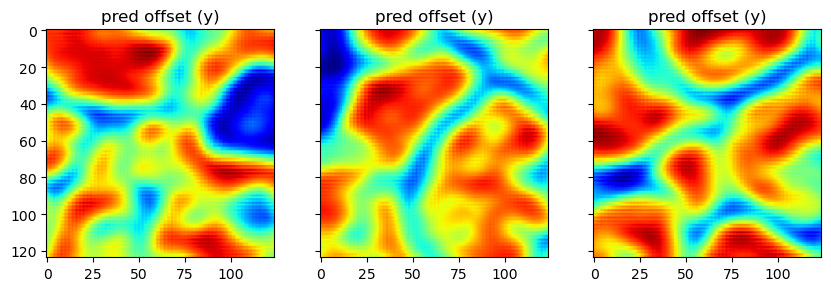

Training iteration 999: 100%|█████████▉| 1000/1001 [01:55<00:00,  8.88it/s]INFO:gunpowder.nodes.generic_train:Train process: iteration=1001 loss=0.031099 time=0.010419


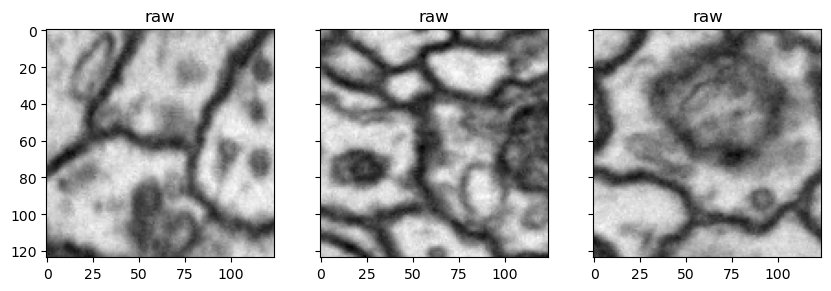

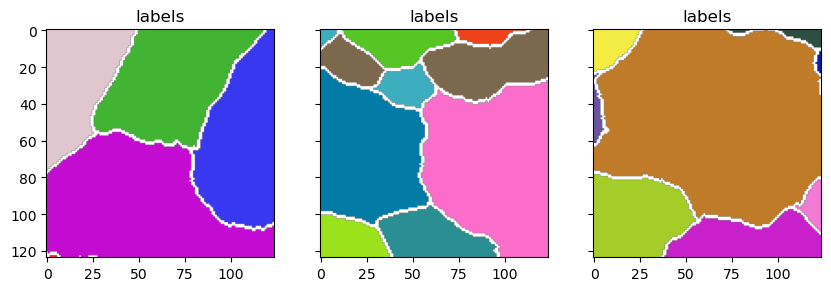

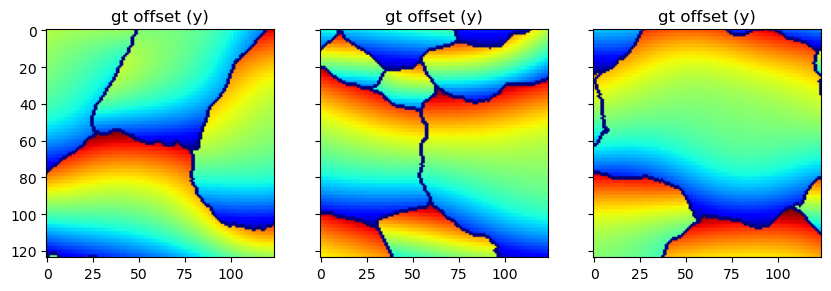

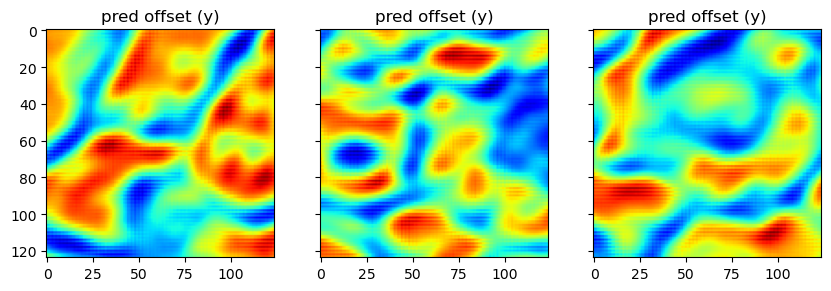

Training iteration 1000: 100%|██████████| 1001/1001 [01:56<00:00,  8.56it/s]INFO:gunpowder.producer_pool:terminating workers...
INFO:gunpowder.producer_pool:joining workers...
INFO:gunpowder.producer_pool:done



In [14]:
# train for ~1k iterations, view every 100th batch
# lets just view the mean offset y channel
# show the prediction as well as the ground truth
# will take longer to converge than affs

channels = {'offset (y)': 0}

train(iterations=1001, batch_size=3, show_every=100, show_pred=True, channels=channels)

*  Just a general idea of how to use gunpowder - the networks in the paper are all in 3d and should be trained on sufficient hardware

*  Results will probably vary since these are 2d slices of 3d data - sometimes more information is required in the z-dimension to inform predictions (especially for neuron segmentation). Feel free to try training for longer.

*  The lsds can also be used in a pure pytorch or tensorflow pipeline (i.e without gunpowder) since they can be calculated as a numpy array on label data

*  see how to train an mtlsd network (similar to network in paper) in  **train_mtlsd.ipynb**